# Exploring the manual classification to determine features for modeling

In [116]:
import pandas as pd
import numpy as np
import math
import pickle
import os
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
import psycopg2

%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from src import util
from src.visualization import scatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Load the dataset from the database 
conn = psycopg2.connect(database="gdelt_social_video", user="postgres")
c = conn.cursor()
# Just work with youtube for now
platform = "youtube"
query = '''SELECT s.article_count, s.source_name, s.youtube_std_dev, s.youtube_sum, s.youtube_count, s.youtube_sum_distinct, lh.youtube_relevant FROM sources s INNER JOIN labeled_sources lh  ON s.source_name=lh.source_name
                                WHERE lh.youtube_relevant <> -1 AND s.youtube_sum > 0'''
samples = pd.read_sql_query(query,con=conn)

#TODO remove the "video" from feature names. Put feature names in array.
samples = samples[["source_name", 
                   "article_count", 
                   "%s_sum" % platform, 
                   "%s_sum_distinct" % platform, 
                   "%s_count" % platform, 
                   "%s_std_dev" % platform, 
                   "%s_relevant" % platform]]

# Compute the remaining interesting features
# Average number of videos per article, including articles without videos
samples["%s_average" % platform] = samples["%s_sum" % platform] / samples["article_count"]
# Average distinct videos per article
samples["%s_average_distinct" % platform] = samples["%s_sum_distinct" % platform] / samples["article_count"]
# Total videos to distinct videos
samples["%s_distinct_to_sum" % platform] = samples["%s_sum_distinct" % platform] / samples["%s_sum" % platform]
# Percentage of articles with videos
samples["%s_percentage" % platform] = samples["%s_count" % platform] / samples["article_count"]
# Binary relevance (used for classification)
samples["%s_relevant_binary" % platform] = samples["%s_relevant" % platform] == 1

samples.head()

,source_name,article_count,youtube_sum,youtube_sum_distinct,youtube_count,youtube_std_dev,youtube_relevant,youtube_average,youtube_average_distinct,youtube_distinct_to_sum,youtube_percentage,youtube_relevant_binary
0,watoday.com.au,408,3,3,2,0.500000,1,0.007353,0.007353,1.000000,0.004902,True
1,nagariknetwork.com,713,1,1,1,0.000000,1,0.001403,0.001403,1.000000,0.001403,True
2,kanw.com,400,39,38,20,1.160819,1,0.097500,0.095000,0.974359,0.050000,True
3,meduza.io,11,1,1,1,0.000000,1,0.090909,0.090909,1.000000,0.090909,True
4,musicconnection.com,15,15,2,15,0.000000,2,1.000000,0.133333,0.133333,1.000000,False


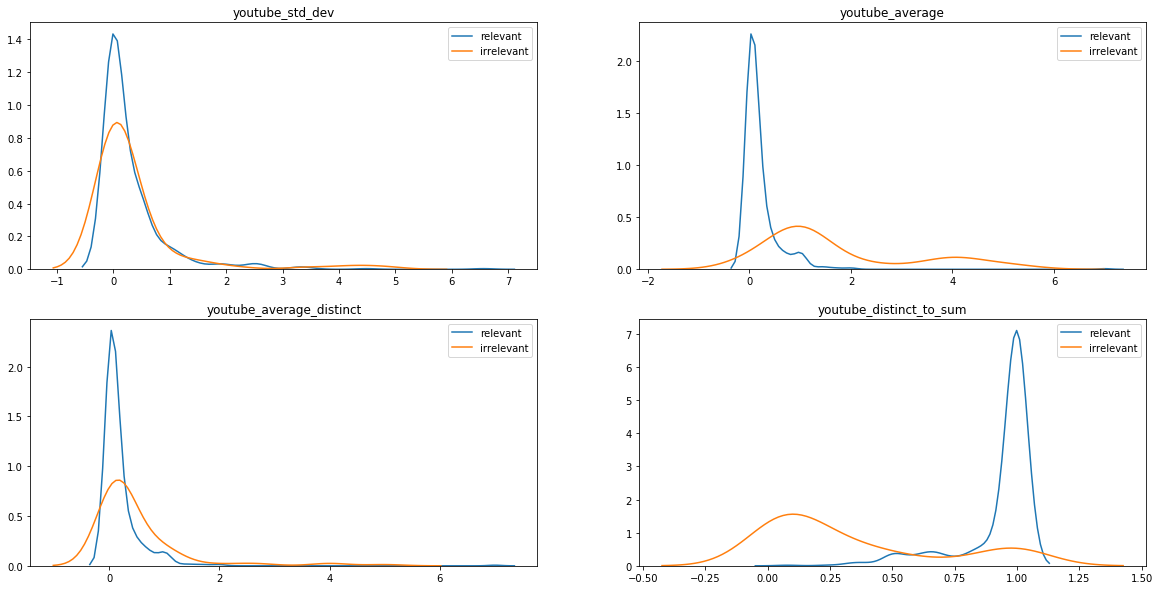

In [36]:
# Plot various interesting densitites
plot_feature_densities = [#"youtube_count", 
                          #"youtube_sum", 
                          #"youtube_sum_distinct",
                          "youtube_std_dev",
                          "youtube_average",
                          "youtube_average_distinct",
                          "youtube_distinct_to_sum"]
f, axarr = plt.subplots(math.ceil(len(plot_feature_densities) / 2), 2, figsize=(20, math.ceil(len(plot_feature_densities) / 2) * 5))
axarr = np.ndarray.flatten(axarr)

relevant_samples = samples[samples["%s_relevant" % platform] == 1]
irrelevant_samples = samples[samples["%s_relevant" % platform] != 1]
for index, feature in enumerate(plot_feature_densities):
    ax = axarr[index]
    sns.kdeplot(data=relevant_samples[feature], ax=ax, label="relevant")
    sns.kdeplot(data=irrelevant_samples[feature], ax=ax, label="irrelevant")
    ax.set_title(plot_feature_densities[index])

#plt.suptitle('Density distributions of features by relevance'); 
plt.savefig(os.environ['FIGURES_PATH'] + "feature_densities.pdf", format="pdf")
plt.show()

In [37]:
len(samples)

645

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


train_on = ["youtube_average", "youtube_distinct_to_sum"] #, "youtube_video_average", "youtube_video_sum"

models = [#svm.SVC(kernel='linear', C=100),# Higher C: Avoid misclassification (vs. optimize distance)
          svm.SVC(kernel='rbf', gamma=.5, C=100, probability=True), # Higher gamma; more clusters
          KNeighborsClassifier(9), # Maybe plot over k
          DecisionTreeClassifier()]

X_train, X_test, y_train, y_test = train_test_split(samples[train_on], samples['%s_relevant_binary' % platform], test_size=0.2)
for model in models:
    model.fit(samples[train_on], samples['%s_relevant_binary' % platform])
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    print(model.score(X_test, y_test))

/Users/claasmeiners/.virtualenvs/thesis/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Accuracy: 0.955 (+/- 0.037)
0.9689922480620154
Accuracy: 0.955 (+/- 0.032)
0.9612403100775194
Accuracy: 0.946 (+/- 0.042)
0.9689922480620154


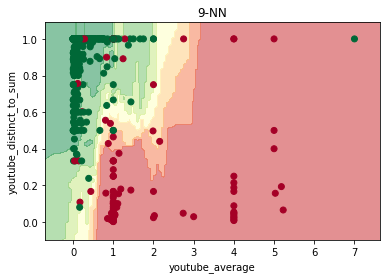

In [50]:
ax = plt.subplot()
scatter.scatter_2D(ax, 
                   samples['youtube_average'], 
                   samples['youtube_distinct_to_sum'], 
                   samples['youtube_relevant_binary'],
                   x_label="youtube_average",
                   y_label="youtube_distinct_to_sum",
                   clf=models[1], title="9-NN")
plt.savefig(os.environ['FIGURES_PATH'] + "source_classifier.pdf", format="pdf")
plt.show()

Average precision-recall score: 0.98


Text(0.5,1,'2-class Precision-Recall curve: AP=0.98')

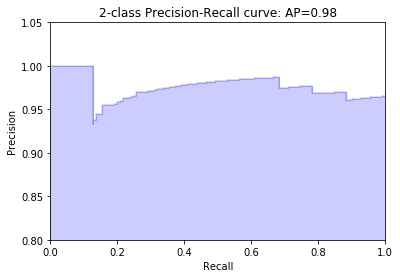

In [60]:
classifier = models[0]

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
y_score = classifier.decision_function(X_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.8, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [81]:
classifier.predict(X_test[:10])

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [84]:
classifier.predict_proba(X_test[:10])

array([[0.83175667, 0.16824333],
       [0.04220699, 0.95779301],
       [0.04421907, 0.95578093],
       [0.04421621, 0.95578379],
       [0.04427264, 0.95572736],
       [0.04425355, 0.95574645],
       [0.0438009 , 0.9561991 ],
       [0.0439102 , 0.9560898 ],
       [0.04421133, 0.95578867],
       [0.04428099, 0.95571901]])

In [101]:
# First probability is probability of False-label
false_threshold = 0.9 # below 0.5
predictions[:10]

[False, True, True, True, True, True, True, True, True, True]

In [102]:
list(y_test)[:10]

[False, True, True, True, True, True, True, True, True, True]

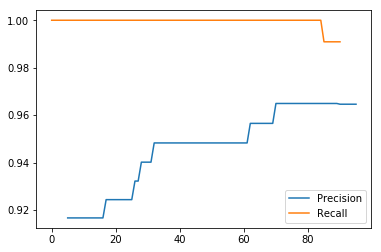

In [121]:
from sklearn.metrics import recall_score, precision_score
import matplotlib.pyplot as plt

bin_preds = classifier.predict_proba(X_test)
precisions = list()
recalls = list()
for percentage in range(5,96):
    false_threshold = percentage/100
    predictions = [pred[1] > false_threshold for pred in bin_preds]
    precisions.append(precision_score(y_true=y_test, y_pred=predictions))
    recalls.append(recall_score(y_pred=predictions, y_true=y_test))
    
plt.plot(range(5,96), precisions, recalls)
plt.legend(["Precision", "Recall"])
plt.savefig(os.environ['FIGURES_PATH'] + "source_classifier_precision_recall.pdf", format="pdf")


In [80]:
# Save the rbf classifier
import time
clf_path = os.environ["MODEL_PATH"] + "svmrbf_%d" % time.time()
pickle.dump(models[0], open(clf_path, "wb+"))

## TODO
- Save classifier
- The classifier can't do much YET. With more data and the advanced features, that will change.
- use percentage of pages crawled from this website that contain ANY video. Right now we're just looking at pages that contain videos at all.
- Look at number of different videos (same video on all pages is a bad sign)